# Conversion of the volume to mass concentrations
This notebook executes the following steps:
* Calculate a theoretical apparent densities for the LISST-200X size classes using the formula from Fall et al. 2021. 
* Average the densities of the different size classes to match the grain size populations
* Convert the predicted TVC grids to Suspended Particulate Matter Concentration (SPMC) grids.
* Saves the SPMC grids to netCDF files

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("pdf", fonttype=42)
from timbers_code.grainsize import get_assemblage_apparent_density
from glob import glob
import os
import xarray as xr

## Set the parameters
* lisst_size_classes: path to the file that defines the size classes. From LISST-200X Manual
* d_p: the primary particle size in µm, below which rho_a = 2500 kg/m3 (Fettweis et al., 2008)
* d_p_li: lower interval of primary particle size in µm for Kwinte study area (Fettweis et al., 2008)
* d_p_ui: upper interval of primary particle size in µm for Kwinte study area (Fettweis et al., 2008) 
* F: Fractal Dimension (Fettweis et al., 2021) 
* F_li: Fractal Dimension, lower interval for Kwinte study area (Fettweis personal communication) 
* F_ui: Fractal Dimension, upper interval for Kwinte study area (Fettweis personal communication) 
* rho_p: primary particle density in kg/m3 (Fettweis et al., 2008)
* raster_path: path where output netCDF files will be stored
* raster_files: netCDF files of predicted TVC data
* bin_boundaries: list of grain size boundaries used to calculate TVC for different grain size populations
* variable_schema: mapping of which which TVC variables (in each of the netCDF files for the different grain size populations/assemblages) should be used to calculate the SPMC variables
* filepath_apparent_densities_plot: file to save the plot of the apparent densities

In [7]:
# input files
lisst_size_classes = 'sensor_data/lisst_size_classes.csv'
# input parameters
d_p = 2 #µm, the primary particle size, below which rho_a = 2500 kg/m3 (Fettweis et al., 2008)
d_p_li = 1 #µm,lower interval of primary particle size for Kwinte study area (Fettweis et al., 2008)
d_p_ui = 3 #µm, upper interval of primary particle size for Kwinte study area (Fettweis et al., 2008) 
F = 2 # Fractal Dimension (Fettweis et al., 2021) 
F_li = 1.9 # Fractal Dimension, lower interval for Kwinte study area (Fettweis personal communication) 
F_ui = 2.1 # Fractal Dimension, upper interval for Kwinte study area (Fettweis personal communication) 
# F_li = 2.04 # Fractal Dimension, lower interval for Kwinte study area (Fettweis et al., 2008) 
# F_ui = 2.12 # Fractal Dimension, upper interval for Kwinte study area (Fettweis et al., 2008) 
rho_p = 2500 #kg/m3 (Fettweis et al., 2008)
# get predicted raster files
raster_path = 'G:/Algorithm2/predictions_final'
raster_files = glob(f'{raster_path}/*/*TVC*.nc') + glob(f'{raster_path}/*/*Total_Volume_Concentration*.nc')
## For size classes based on Fetweiss et al 2014
# bin_boundaries = np.array([15.,200.]) #assemblage boundaries
# variable_schema = pd.DataFrame({'SPMC_mean': ['TVC_(0.0,_15.0]_mean','TVC_(15.0,_200.0]_mean','TVC_(200.0,_459.0]_mean','Total_Volume_Concentration_[ppm]_mean'],
#                                  'SPMC_ci_lower':['TVC_(0.0,_15.0]_obs_ci_lower','TVC_(15.0,_200.0]_obs_ci_lower','TVC_(200.0,_459.0]_obs_ci_lower','Total_Volume_Concentration_[ppm]_obs_ci_lower'],
#                                  'SPMC_ci_upper':['TVC_(0.0,_15.0]_obs_ci_upper','TVC_(15.0,_200.0]_obs_ci_upper','TVC_(200.0,_459.0]_obs_ci_upper','Total_Volume_Concentration_[ppm]_obs_ci_upper']},
#                                 index = pd.Series(['(0.0, 15.0]', '(15.0, 200.0]', '(200.0, 459.0]','(0.0, 459.0]']).rename('Assemblage'))
## For size classes based on Lee et al 2012
bin_boundaries = np.array([3.,20.,200.]) #assemblage boundaries
variable_schema = pd.DataFrame({'SPMC_mean': ['TVC_(0.0,_3.0]_mean','TVC_(3.0,_20.0]_mean','TVC_(20.0,_200.0]_mean','TVC_(200.0,_420.0]_mean','Total_Volume_Concentration_[ppm]_mean'],
                                 'SPMC_ci_lower':['TVC_(0.0,_3.0]_obs_ci_lower','TVC_(3.0,_20.0]_obs_ci_lower','TVC_(20.0,_200.0]_obs_ci_lower','TVC_(200.0,_420.0]_obs_ci_lower','Total_Volume_Concentration_[ppm]_obs_ci_lower'],
                                 'SPMC_ci_upper':['TVC_(0.0,_3.0]_obs_ci_upper','TVC_(3.0,_20.0]_obs_ci_upper','TVC_(20.0,_200.0]_obs_ci_upper','TVC_(200.0,_420.0]_obs_ci_upper','Total_Volume_Concentration_[ppm]_obs_ci_upper']},
                                index = pd.Series(['(0.0, 3.0]','(3.0, 20.0]','(20.0, 200.0]', '(200.0, 459.0]','(0.0, 459.0]']).rename('Assemblage'))
# output files
filepath_apparent_densities_plot = 'publication_output/apparent_densities.pdf'

In [ ]:
variable_schema

,SPMC_mean,SPMC_ci_lower,SPMC_ci_upper
Assemblage,,,
"(0.0, 3.0]","TVC_(0.0,_3.0]_mean","TVC_(0.0,_3.0]_obs_ci_lower","TVC_(0.0,_3.0]_obs_ci_upper"
"(3.0, 20.0]","TVC_(3.0,_20.0]_mean","TVC_(3.0,_20.0]_obs_ci_lower","TVC_(3.0,_20.0]_obs_ci_upper"
"(20.0, 200.0]","TVC_(20.0,_200.0]_mean","TVC_(20.0,_200.0]_obs_ci_lower","TVC_(20.0,_200.0]_obs_ci_upper"
"(200.0, 459.0]","TVC_(200.0,_420.0]_mean","TVC_(200.0,_420.0]_obs_ci_lower","TVC_(200.0,_420.0]_obs_ci_upper"
"(0.0, 459.0]",Total_Volume_Concentration_[ppm]_mean,Total_Volume_Concentration_[ppm]_obs_ci_lower,Total_Volume_Concentration_[ppm]_obs_ci_upper


## Read in size classes, exported from the LISST manual

In [4]:
size_classes = pd.read_csv(lisst_size_classes)
size_classes = size_classes.set_index('Size_bin')

## Calculate the apparent densities

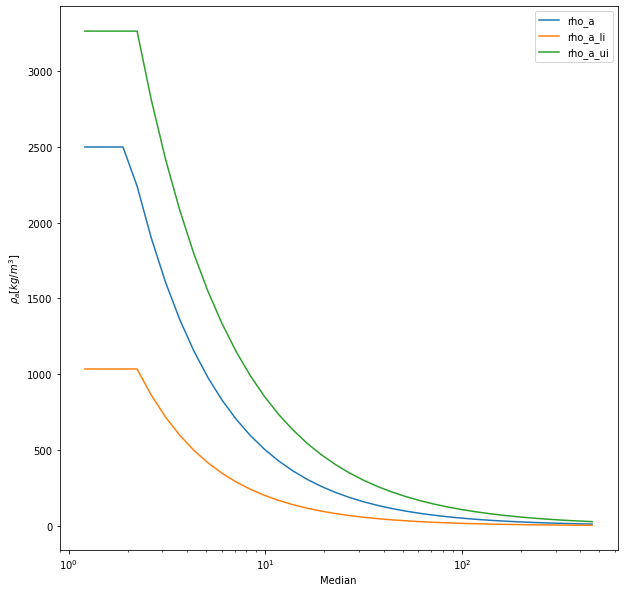

In [8]:
apparent_densities = get_assemblage_apparent_density(size_classes = size_classes.Median, bin_boundaries = bin_boundaries,
                                rho_p=rho_p, d_p=d_p, d_p_li=d_p_li,d_p_ui=d_p_ui,
                                F=F, F_li=F_li, F_ui=F_ui,plot=True)
plt.savefig(filepath_apparent_densities_plot, bbox_inches = 'tight')

# Merge the average apparent densities for each grain size population on the variable schema

In [6]:
apparent_densities = apparent_densities.merge(variable_schema, left_index=True, right_index=True, how = 'outer')
apparent_densities

,rho_a,rho_a_li,rho_a_ui,SPMC_mean,SPMC_ci_lower,SPMC_ci_upper
Assemblage,,,,,,
"(0.0, 3.0]",2328.658630,1000.332554,3174.833405,"TVC_(0.0,_3.0]_mean","TVC_(0.0,_3.0]_obs_ci_lower","TVC_(0.0,_3.0]_obs_ci_upper"
"(3.0, 20.0]",757.798133,318.871040,1213.433144,"TVC_(3.0,_20.0]_mean","TVC_(3.0,_20.0]_obs_ci_lower","TVC_(3.0,_20.0]_obs_ci_upper"
"(20.0, 200.0]",93.086999,31.924500,183.024290,"TVC_(20.0,_200.0]_mean","TVC_(20.0,_200.0]_obs_ci_lower","TVC_(20.0,_200.0]_obs_ci_upper"
"(200.0, 459.0]",15.866572,4.477126,37.806383,"TVC_(200.0,_420.0]_mean","TVC_(200.0,_420.0]_obs_ci_lower","TVC_(200.0,_420.0]_obs_ci_upper"
"(0.0, 459.0]",614.428377,258.262330,921.853798,Total_Volume_Concentration_[ppm]_mean,Total_Volume_Concentration_[ppm]_obs_ci_lower,Total_Volume_Concentration_[ppm]_obs_ci_upper


# Calculate the SPMC for the different grain size populations
This is done by multiplying apparent density (in g/cm3) with TVC (in ul/l). Dividing by 1000 gives the SPMC in kg/m3.

The SPMC grids are then written to a netCDF file.

In [7]:
%%time
for raster_file in raster_files:
    # read the raster and it's data variables
    raster = xr.open_dataset(raster_file)
    data_vars = list(raster.data_vars)
    data_vars.remove('spatial_ref')
    for var in data_vars:
        # if the var matches a SPMC_mean colun, multiply with rho_a
        match = apparent_densities[apparent_densities.SPMC_mean == var]
        if len(match) != 0:
            assemblage = match.index.str.replace(' ','_')[0]
            raster[f'SPMC_{assemblage}_mean'] = raster[var] *match['rho_a'].values[0]/1000
        # if the var matches a SPMC_ci_lower column, multiply with rho_a_li
        match = apparent_densities[apparent_densities.SPMC_ci_lower == var]
        if len(match) != 0:
            assemblage = match.index.str.replace(' ','_')[0]
            raster[f'SPMC_{assemblage}_ci_lower'] = raster[var] * match['rho_a_li'].values[0]/1000
        # if the var matches a SPMC_ci_upper column, multiply with rho_a_ui
        match = apparent_densities[apparent_densities.SPMC_ci_upper == var]
        if len(match) != 0:
            assemblage = match.index.str.replace(' ','_')[0]
            raster[f'SPMC_{assemblage}_ci_upper'] = raster[var] *match['rho_a_ui'].values[0]/1000
        # remove the original variable
        raster = raster.drop_vars(var)
    # write the resulting raster to a file
    file_path = os.path.dirname(raster_file)
    file_name = f'{os.path.split(file_path)[-1]}_SPMC_{assemblage}.nc'
    raster.to_netcdf(os.path.join(file_path, file_name))

Wall time: 4min 11s
